In [158]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [159]:
df_news = pd.read_csv("../data/spy/news_spy_2022.csv", index_col=0)
df_price = pd.read_csv("../data/spy/price_spy_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:17:30  The Week On Wall Street: The Santa Rally Yield...
1 2022-01-01 01:03:35  2 Little Known Dividend Growth Powerhouses For...
2 2022-01-01 02:05:22  Covid Omicron In Rear View Mirror: Will We Be ...
3 2022-01-01 07:03:26  2021's Risk-Adjusted Returns In Context, And O...
4 2022-01-01 07:39:31  8 Charts That Tell The Stock Market Story Of 2...
                 date       price
0 2022-01-03 09:31:00  463.705261
1 2022-01-03 09:32:00  463.933970
2 2022-01-03 09:33:00  463.783120
3 2022-01-03 09:34:00  464.225939
4 2022-01-03 09:35:00  464.298932


In [180]:
dfs = []
for i in range(1, 4):
    df_score = pd.read_csv(f"../data/spy/news_score_spy_2022_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/spy/news_score_spy_2022_all.csv")
df_score

(1031, 3)
(700, 3)
(1031, 3)


,date,score
0,2022-01-01 00:17:30,1
1,2022-01-01 11:01:39,1
2,2022-01-02 04:32:18,1
3,2022-01-02 16:24:23,-1
4,2022-01-03 07:40:39,0
...,...,...
2757,2022-12-30 07:53:20,0
2758,2022-12-30 13:01:34,1
2759,2022-12-30 17:03:47,0
2760,2022-12-31 08:29:25,-1


In [161]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2022-01-01 00:17:30,1
1,2022-01-01 01:03:35,1
2,2022-01-01 02:05:22,0
3,2022-01-01 11:01:39,1
4,2022-01-01 13:05:21,1
...,...,...
2757,2022-12-30 17:03:47,0
2758,2022-12-31 04:56:14,-1
2759,2022-12-31 08:29:25,-1
2760,2022-12-31 15:00:22,0


In [162]:
df_score["score"].value_counts()

 1    1059
 0     959
-1     739
 5       5
Name: score, dtype: int64

In [163]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [164]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [165]:
df_news.shape

(10303, 2)

In [166]:

columns = ["price_now", "price_in5", "price_in10", "price_in30", "price_in60"]
deltas = [0, 5, 10, 30, 60]
pd_price = np.zeros((df_news.shape[0], 5))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(5):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [167]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [168]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = ["return_in5", "return_in10", "return_in20", "return_in60"]
price_cols = ["price_in5", "price_in10", "price_in30", "price_in60"]

for i in range(4):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_now"]) / result_df["price_now"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df

,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
50,2022-01-03 11:29:45,"Pre-Markets Up to Start 2022, Jobs WeekPre-mar...",462.790425,1.0,-0.000673,-0.002040,-0.000336,0.000862
51,2022-01-03 12:08:25,Dogs Of The Dow Performance Does Not Keep Pace...,462.663905,-1.0,0.000231,0.000463,0.000631,0.000252
52,2022-01-03 12:21:15,Why Doesn't Increased Demand Bring More Supply...,463.043465,0.0,0.000189,-0.000021,0.000273,0.000715
90,2022-01-04 14:27:18,SPXS And Leveraged ETFs: January Drift Dashboa...,463.753923,-1.0,0.001280,0.000923,0.001931,0.003421
91,2022-01-04 14:30:24,Why Roblox Stock Could Provide Solid Entry For...,464.021561,1.0,0.000367,0.000650,0.001563,0.002737
...,...,...,...,...,...,...,...,...
10220,2022-12-28 14:16:15,S&P 500 Forecasts For Year-End 2023Historical ...,374.255399,-1.0,0.000396,0.000291,0.001823,-0.002669
10240,2022-12-29 10:06:26,2022 Review: US Equity SectorsAnnual returns f...,377.603235,1.0,0.001323,0.002187,0.002881,0.002842
10242,2022-12-29 11:05:25,S&P 500 End Of 2023: The 'Flaw' Of AveragesHow...,378.780169,0.0,-0.000796,-0.001044,0.001123,0.001867
10270,2022-12-30 11:33:23,U.S. Weekly FundFlows Insight Report: Heading ...,376.21366,-1.0,0.000421,0.000079,0.000815,0.001341


In [169]:
result_df = result_df.dropna()

In [170]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_3932/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,price_now,score,return_in5,return_in10,return_in20,return_in60
count,808,808,808.00000,808.000000,808.000000,808.000000,808.000000,808.000000
unique,808,808,761.00000,NaN,NaN,NaN,NaN,NaN
top,2022-01-03 11:29:45,"Pre-Markets Up to Start 2022, Jobs WeekPre-mar...",432.07528,NaN,NaN,NaN,NaN,NaN
freq,1,1,3.00000,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 11:29:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-30 13:01:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.152228,-0.000063,0.000039,0.000218,0.000326
std,NaN,NaN,NaN,0.837678,0.001271,0.001816,0.003156,0.004552
min,NaN,NaN,NaN,-1.000000,-0.004806,-0.008186,-0.012493,-0.016550
25%,NaN,NaN,NaN,-1.000000,-0.000696,-0.000995,-0.001722,-0.002341


In [171]:
result_df.dtypes

date           datetime64[ns]
news                   object
price_now              object
score                 float64
return_in5            float64
return_in10           float64
return_in20           float64
return_in60           float64
dtype: object

In [172]:
correlation_matrix = result_df[["score", 'return_in5', 'return_in10', 'return_in20', 'return_in60']].corr()

In [173]:
correlation_matrix

,score,return_in5,return_in10,return_in20,return_in60
score,1.000000,0.073082,0.068707,0.044186,0.036033
return_in5,0.073082,1.000000,0.681139,0.416516,0.203275
return_in10,0.068707,0.681139,1.000000,0.613558,0.403083
return_in20,0.044186,0.416516,0.613558,1.000000,0.716394
return_in60,0.036033,0.203275,0.403083,0.716394,1.000000


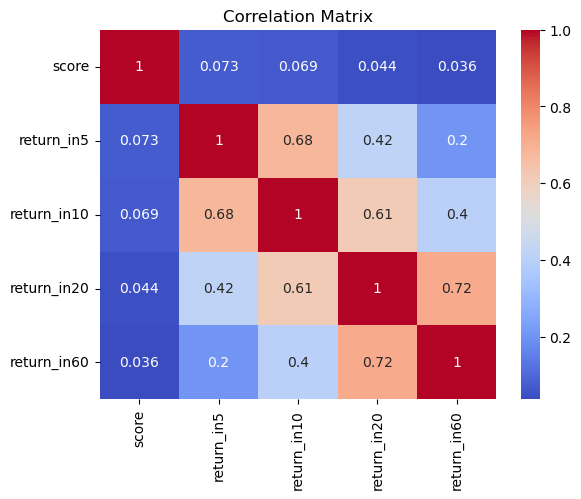

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

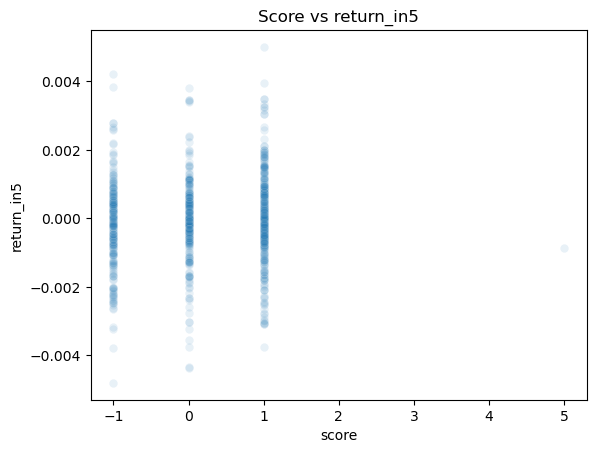

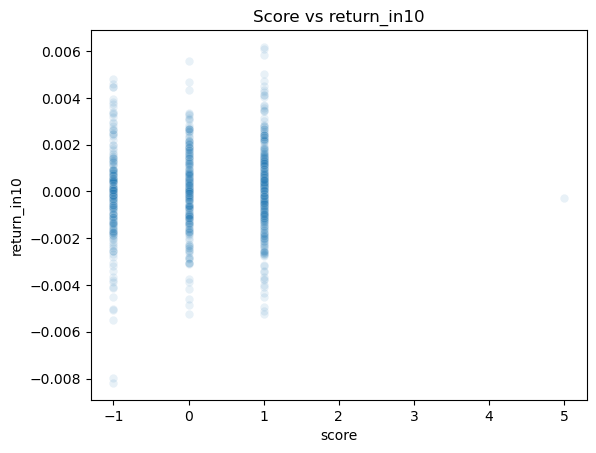

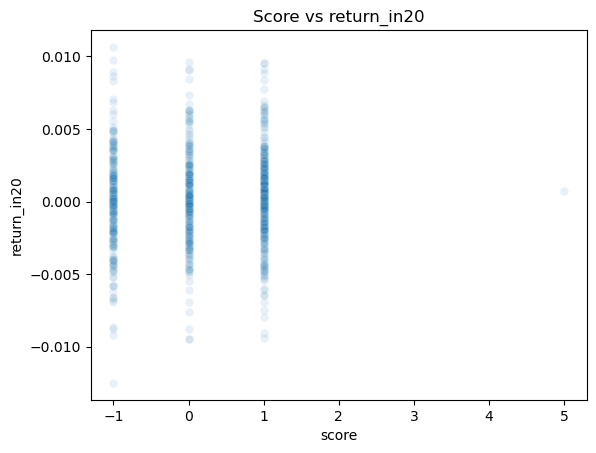

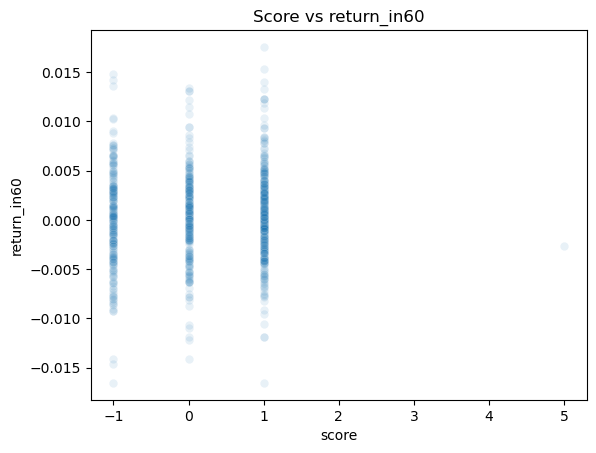

In [175]:
for return_col in ['return_in5', 'return_in10', 'return_in20', 'return_in60']:
    sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.1)
    plt.title(f'Score vs {return_col}')
    plt.show()

In [176]:
np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]]).shape

(808, 4)

In [177]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = np.array(result_df["score"]).reshape(-1,1)
y = np.array(result_df[["return_in5", "return_in10","return_in20","return_in60"]])
lr.fit(X, y)

LinearRegression()

In [178]:
lr.coef_

array([[0.00011093],
       [0.00014892],
       [0.0001665 ],
       [0.00019579]])

In [179]:
return_names = ["return_in5", "return_in10","return_in20","return_in60"]
for name in return_names:
    for j in [-1, 0, 1]:
        print(f"When score is {j}, the mean {name} is {result_df[result_df['score'] == j][name].mean()*10000}")
    

When score is -1, the mean return_in5 is -2.0829037435533277
When score is 0, the mean return_in5 is -0.7174281052876549
When score is 1, the mean return_in5 is 0.3928756283083831
When score is -1, the mean return_in10 is -1.6278230532620626
When score is 0, the mean return_in10 is 0.527407143256478
When score is 1, the mean return_in10 is 1.6056916157909618
When score is -1, the mean return_in20 is 0.16862508217628586
When score is 0, the mean return_in20 is 2.0306883989498656
When score is 1, the mean return_in20 is 3.5735419334940213
When score is -1, the mean return_in60 is 0.1405497904798895
When score is 0, the mean return_in60 is 3.8704647355111943
When score is 1, the mean return_in60 is 4.936552051361232
